In [15]:
# Import the necessary modules
import os
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
import torchvision.transforms as transforms

In [16]:
# Define the hyperparameters
batch_size = 128        # Higher batch size to better utilize GPU memory
latent_dim = 100        # Dimension of the latent space (this is fine for MNIST)
num_epochs = 100        # Training for 100 epochs is often enough for MNIST
lr = 0.0002             # This learning rate works well with Adam optimizer
beta1 = 0.5             # A common choice for GANs to help with stable convergence

In [17]:
# Create a directory images if not exists
if not os.path.exists("images"):
    os.makedirs("images")

In [18]:
# Create the dataloader for MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert the images to tensors
        transforms.Normalize((0.5,), (0.5,)),  # Normalize the images to [-1, 1] range
    ]
)
dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [19]:
# Define the device to use (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [20]:
# Define the generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # A sequential container of layers
        self.main = nn.Sequential(
            # A linear layer that maps the latent vector to 256*7*7 features
            nn.Linear(latent_dim, 256 * 7 * 7),
            # A batch normalization layer to stabilize the training
            nn.BatchNorm1d(256 * 7 * 7),
            # A leaky ReLU activation function with negative slope 0.2
            nn.LeakyReLU(0.2),
            # Reshape the features to a 4D tensor of shape (batch_size, 256, 7, 7)
            nn.Unflatten(1, (256, 7, 7)),
            # A transposed convolution layer that upsamples the features to 128*14*14
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            # A batch normalization layer
            nn.BatchNorm2d(128),
            # A leaky ReLU activation function
            nn.LeakyReLU(0.2),
            # A transposed convolution layer that upsamples the features to 64*28*28
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            # A batch normalization layer
            nn.BatchNorm2d(64),
            # A leaky ReLU activation function
            nn.LeakyReLU(0.2),
            # A transposed convolution layer that upsamples the features to 1*28*28
            nn.ConvTranspose2d(64, 1, 3, 1, 1),
            # A tanh activation function to output values in [-1, 1] range
            nn.Tanh(),
        )

    def forward(self, x):
        # The forward pass of the generator network
        return self.main(x)


# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # A sequential container of layers
        self.main = nn.Sequential(
            # A convolution layer that downsamples the images to 64*14*14 features
            nn.Conv2d(1, 64, 4, 2, 1),
            # A leaky ReLU activation function with negative slope 0.2
            nn.LeakyReLU(0.2),
            # A convolution layer that downsamples the features to 128*7*7 features
            nn.Conv2d(64, 128, 4, 2, 1),
            # A batch normalization layer to stabilize the training
            nn.BatchNorm2d(128),
            # A leaky ReLU activation function
            nn.LeakyReLU(0.2),
            # Flatten the features to a 1D tensor of shape (batch_size, 128*7*7)
            nn.Flatten(),
            # A linear layer that maps the features to a single output value
            nn.Linear(128 * 7 * 7, 1),
            # A sigmoid activation function to output a probability in [0, 1] range
            nn.Sigmoid(),
        )

    def forward(self, x):
        # The forward pass of the discriminator network
        return self.main(x)


# Create an instance of the generator and the discriminator networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)


# Define the loss function (binary cross entropy)
criterion = nn.BCELoss()


# Define the optimizers for the generator and the discriminator
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [21]:
# Define a function to generate a batch of latent vectors
def generate_latent_vectors(batch_size, latent_dim):
    # Generate a batch of random vectors from a normal distribution
    return torch.randn(batch_size, latent_dim, device=device)


# Define a function to generate a batch of fake labels
def generate_fake_labels(batch_size):
    # Generate a batch of zeros
    return torch.zeros(batch_size, device=device)


# Define a function to generate a batch of real labels
def generate_real_labels(batch_size):
    # Generate a batch of ones
    return torch.ones(batch_size, device=device)

In [22]:
def save_images(epoch, generator, dataloader):
    # Generate a batch of latent vectors
    latent_vectors = generate_latent_vectors(batch_size, latent_dim).to(device)
    # Generate a batch of fake images using the generator
    fake_images = generator(latent_vectors)
    # Move the fake images to the same device as the real images
    fake_images = fake_images.to(device)
    # Concatenate the real images and the fake images along the horizontal axis
    images = torch.cat([real_images, fake_images], dim=3)
    # Move the images to the CPU
    images = images.cpu()
    # Save the images
    save_image(images, f"images/image_{epoch}.png")

In [23]:
# Train the GAN model
for epoch in range(1, num_epochs + 1):
    # Loop over the batches in the dataloader
    for i, (real_images, _) in enumerate(dataloader):
        # Get the batch size from the real images
        batch_size = real_images.size(0)
        # Move the real images to the device
        real_images = real_images.to(device)
        # Generate a batch of latent vectors
        latent_vectors = generate_latent_vectors(batch_size, latent_dim)
        # Generate a batch of fake images using the generator
        # Generate a batch of latent vectors
        latent_vectors = generate_latent_vectors(batch_size, latent_dim)
        # Reshape the latent vectors to match the expected input shape of the generator
        latent_vectors = latent_vectors.view(batch_size, latent_dim)
        # Generate a batch of fake images using the generator
        fake_images = generator(latent_vectors)
        # Generate a batch of fake labels
        fake_labels = generate_fake_labels(batch_size)
        # Generate a batch of real labels
        real_labels = generate_real_labels(batch_size)
        # Compute the discriminator outputs for the real images and the fake images
        output_real = discriminator(real_images).view(-1)
        output_fake = discriminator(fake_images.detach()).view(-1)
        # Compute the discriminator loss for the real images and the fake images
        loss_D_real = criterion(output_real, real_labels)
        loss_D_fake = criterion(output_fake, fake_labels)
        # Compute the total discriminator loss
        loss_D = (loss_D_real + loss_D_fake) / 2
        # Zero the gradients of the discriminator parameters
        optimizer_D.zero_grad()
        # Backpropagate the discriminator loss
        loss_D.backward()
        # Update the discriminator parameters using the optimizer
        optimizer_D.step()
        # Compute the generator output for the fake images
        output_G = discriminator(fake_images).view(-1)
        # Compute the generator loss using the discriminator output
        loss_G = criterion(output_G, real_labels)
        # Zero the gradients of the generator parameters
        optimizer_G.zero_grad()
        # Backpropagate the generator loss
        loss_G.backward()
        # Update the generator parameters using the optimizer
        optimizer_G.step()

        # Print the losses and save the images every 200 batches
        if (i + 1) % 200 == 0:
            print(
                f"Epoch {epoch}, Batch {i + 1}, Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}"
            )
            save_images(epoch, generator, dataloader)

Epoch 1, Batch 200, Loss_D: 0.0014, Loss_G: 6.6812
Epoch 1, Batch 400, Loss_D: 0.0006, Loss_G: 7.6315
Epoch 2, Batch 200, Loss_D: 0.0002, Loss_G: 8.7008
Epoch 2, Batch 400, Loss_D: 0.0001, Loss_G: 9.2492
Epoch 3, Batch 200, Loss_D: 0.0001, Loss_G: 9.8277
Epoch 3, Batch 400, Loss_D: 0.0008, Loss_G: 7.7602
Epoch 4, Batch 200, Loss_D: 0.0002, Loss_G: 9.2204
Epoch 4, Batch 400, Loss_D: 0.0001, Loss_G: 9.6866
Epoch 5, Batch 200, Loss_D: 0.0000, Loss_G: 10.7227
Epoch 5, Batch 400, Loss_D: 0.0000, Loss_G: 10.6927
Epoch 6, Batch 200, Loss_D: 0.0000, Loss_G: 11.0679
Epoch 6, Batch 400, Loss_D: 0.0000, Loss_G: 11.1540
Epoch 7, Batch 200, Loss_D: 0.0000, Loss_G: 11.6703
Epoch 7, Batch 400, Loss_D: 0.0000, Loss_G: 12.0308
Epoch 8, Batch 200, Loss_D: 0.0000, Loss_G: 12.3097
Epoch 8, Batch 400, Loss_D: 0.0000, Loss_G: 12.4944
Epoch 9, Batch 200, Loss_D: 0.0000, Loss_G: 12.6034
Epoch 9, Batch 400, Loss_D: 0.0000, Loss_G: 12.6321
Epoch 10, Batch 200, Loss_D: 0.0000, Loss_G: 12.9751
Epoch 10, Batch 400

In [24]:
# Save the final images after training
save_images("final", generator, dataloader)

# Save the generator and discriminator models to files
state_dicts = {
    "generator": generator.state_dict(),
    "discriminator": discriminator.state_dict(),
}

torch.save(state_dicts, "MNIST_GAN.pt")

In [25]:
# Load the state dicts into your models
checkpoint = torch.load("MNIST_GAN.pt")
generator.load_state_dict(checkpoint["generator"])
discriminator.load_state_dict(checkpoint["discriminator"])

summary(generator, input_size=(100,))
summary(discriminator, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 12544]       1,266,944
       BatchNorm1d-2                [-1, 12544]          25,088
         LeakyReLU-3                [-1, 12544]               0
         Unflatten-4            [-1, 256, 7, 7]               0
   ConvTranspose2d-5          [-1, 128, 14, 14]         524,416
       BatchNorm2d-6          [-1, 128, 14, 14]             256
         LeakyReLU-7          [-1, 128, 14, 14]               0
   ConvTranspose2d-8           [-1, 64, 28, 28]         131,136
       BatchNorm2d-9           [-1, 64, 28, 28]             128
        LeakyReLU-10           [-1, 64, 28, 28]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]             577
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 1,948,545
Trainable params: 1,948,545
Non-trainable params: 0
---------------------------

C:\Users\PC\AppData\Local\Temp\ipykernel_15500\794719855.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("MNIST_GAN.pt")


In [26]:
# Switch the generator to evaluation mode
generator.eval()  # This is crucial to ensure BatchNorm uses running mean/variance

Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
  )
)

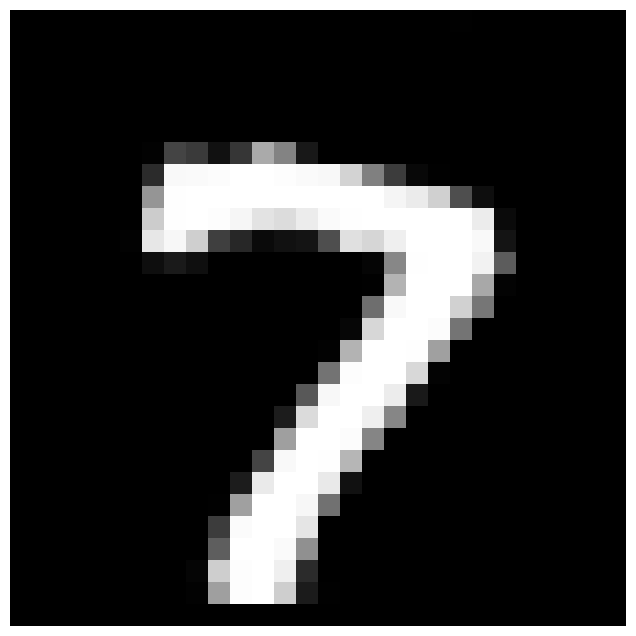

In [59]:
# Prepare your noise vector
noise = torch.randn(1, 100).to("cuda")

# Generate an image
with torch.no_grad():
    # Pass noise through the generator
    # It will reshape internally as per the generator's architecture
    fake_image = generator(noise)

# Convert the grid of images to a numpy array and squeeze to drop any unit dimensions
ndarr = fake_image.cpu().squeeze().numpy()

# Plot the single image
plt.figure(figsize=(8, 8))
plt.imshow(ndarr, cmap="gray", interpolation="nearest")  # Grayscale image
plt.axis("off")
plt.show()